# Pressure Simulations

##### Author: Hrönn Kjartansdóttir
##### Methanogenesis model where CO2 is the limiting factor and pH is implemented

In [ ]:
# Import all packages needed for the model
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

import matplotlib.pyplot as plt
import pandas as pd

import random

import os
os.chdir('C:\\Users\\hronn\\Desktop\\Jupyter\\simulations')

In [3]:
# Set all global variables for the model

        # Molecular weight of liquids:
M_H2  = 2.016*1e-3 # mol/m3
M_CO2 = 44.009*1e-3 # mol/m3
M_CH4 = 16.043*1e-3 # mol/m3
M_H2O = 18.015*1e-3 # mol/m3

        #Liquid density:
density_l = 992.2 # kg/m³

        #Sandrock porosity:
pore = 0.2 # %

        # Dissolution/evaporation rate constants:
K_diss_H2 = 1.05e-2
K_diss_CO2 = 1.87e-3
K_diss_CH4 = 9.32e-5

K_evap_CH4 = 1.81e-2

        # Maximum biomass growth rate:
mu_max = 0.0427 # 1/s

        #temperature:
temperature = 273+40 # Kelvin (K)

        #max uptake rates:
r_H2_max = 1 #mmol/g*h
r_CH4_min = 0 #mmol/g*h
r_CO2_max = r_H2_max / 4 #mmol/g*h

        #Henry solubility constants:
H_H2 = 7.13e-9*1e3
H_CO2 = 2.31e-7*1e3
H_CH4 = 1.08e-8*1e3

        #Pressure in reactor at end of evaporation phase
pressureCH4resid = 2.06e5 # Pa


In [4]:
# RK45() to track time propagation. All previous parameters of interest have been set to their optimal value

def rk45(t, y):
    w_g_H2, w_g_CO2, w_g_CH4, w_l_H2, w_l_CO2, w_l_CH4, m, density_g, S_liq = y
    
            #molecular weight of gasses:
    M_g = ((w_g_H2/M_H2) + (w_g_CO2/M_CO2) + (w_g_CH4/M_CH4))**-1
    
            #gas pressure:
    R_gas = 8.314 / M_g
    pressure_g = density_g * R_gas * temperature

            # Mole fractions of components in gas phase:
    x_g_H2 = (w_g_H2/M_H2)*M_g
    x_g_CO2 = (w_g_CO2/M_CO2)*M_g
    x_g_CH4 = (w_g_CH4/M_CH4)*M_g

            #mass fraction of liquid H2O:
    w_l_H2O = 1 - (w_l_H2 + w_l_CO2 + w_l_CH4)

            # Molecular weight of liquids:
    M_l = ((w_l_H2/M_H2) + (w_l_CO2/M_CO2) + (w_l_CH4/M_CH4) + (w_l_H2O/M_H2O))**-1


            # Mole fractions of components in liquid phase:
    x_l_H2 = (w_l_H2/M_H2)*M_l
    x_l_CO2 = (w_l_CO2/M_CO2)*M_l
    x_l_CH4 = (w_l_CH4/M_CH4)*M_l

            # Saturated mole fraction of components in liquid phase:
    x_l_sat_H2 = (M_l/density_l) * H_H2 * x_g_H2 * pressure_g
    x_l_sat_CO2 = (M_l/density_l) * H_CO2 * x_g_CO2 * pressure_g
    x_l_sat_CH4 = (M_l/density_l) * H_CH4 * x_g_CH4 * pressure_g
       
       
            #source term due to dissolution/evaporation
    R_diss_H2  = K_diss_H2*(x_l_sat_H2 - x_l_H2)
    R_diss_CO2 = K_diss_CO2*(x_l_sat_CO2 - x_l_CO2)

    if x_l_CH4 < x_l_sat_CH4:
        R_diss_CH4 = K_diss_CH4*(x_l_sat_CH4 - x_l_CH4)
    else:
        R_diss_CH4 = K_evap_CH4*(x_l_sat_CH4 - x_l_CH4)


    R_diss_tot = R_diss_H2 + R_diss_CO2 + R_diss_CH4

            #Source for saturation of liquid phase:
    source_S_liq = (1/(pore*density_l))*R_diss_tot
       
            #saturation of gas phase:
    S_gas = 1 - S_liq
    
    
            # Calculate pH:
    #####################################
    

    U_CO2 = 10**5.08
    K_Monod_H2 = 10**-6.09
    K_Monod_CO2 = 10**-6.12
    d = 10**-4.19
    sigma = 10**-0.14

    
    k1 = 5.105e-7 #at 40°C and Salinity of 0‰
    density_l_new = 0.9922 #kg/L
    
    c_CO2 = (x_l_CO2 * density_l_new) / M_l # CO2 concentration in mol/L
    
    
    if c_CO2 < 1.96 * 1e-8:
        pH = 7   
    else:
        pH = -np.log10((k1 * c_CO2)**0.5)  
    
  
    factor = sigma**2 / ( (pH-7.5)**2 + sigma**2)
       
            #uptake/production rates of H2, CO2, CH4 (r_(i)):
    r_CO2  = min(U_CO2 * x_l_CO2 , r_CO2_max) * factor #mol of CO2 / kg of dry biomass / hour
    mu_monod = mu_max * (x_l_H2 / (K_Monod_H2 + x_l_H2)) * (x_l_CO2 / (K_Monod_CO2 + x_l_CO2))
    mu = min((mu_monod  * factor), (r_CO2 * mu_max / r_CO2_max))
        
    
    r_H2 = r_CO2 * 4
    r_CH4 = r_CO2 - (5.855 * mu)

            #Biomass change over time
    source_m = ((mu - d) * m)/3600 # divide by 3600 to get all units in si units (from hour to seconds)

            #Source term for production/uptake
    R_uptake_H2 = (-r_H2*m*M_H2*S_liq*pore)/3600
    R_uptake_CO2 = (-r_CO2*m*M_CO2*S_liq*pore)/3600
    R_uptake_CH4 = (r_CH4*m*M_CH4*S_liq*pore)/3600


            #Source of mass fractions change over time
    source_w_l_H2 = 1/(pore*density_l*S_liq) * (R_uptake_H2 + R_diss_H2 - (w_l_H2 * R_diss_tot))
    source_w_l_CO2 = 1/(pore*density_l*S_liq) * (R_uptake_CO2 + R_diss_CO2 - (w_l_CO2 * R_diss_tot))
    source_w_l_CH4 = 1/(pore*density_l*S_liq) * (R_uptake_CH4 + R_diss_CH4 - (w_l_CH4 * R_diss_tot))

            #gas density change
    source_density_g = -(R_diss_tot / (pore * S_gas)) * (1 - (density_g / density_l))
        
             #mass fraction change 
    source_w_g_H2 = -(1/(pore*density_g*S_gas)) * (R_diss_H2 - w_g_H2 * R_diss_tot) 
    source_w_g_CO2 = -(1/(pore*density_g*S_gas)) * (R_diss_CO2 - w_g_CO2 * R_diss_tot) 
    source_w_g_CH4 = -(1/(pore*density_g*S_gas)) * (R_diss_CH4 - w_g_CH4 * R_diss_tot) 
    

    return [source_w_g_H2, source_w_g_CO2, source_w_g_CH4, source_w_l_H2, source_w_l_CO2, source_w_l_CH4, source_m, source_density_g, source_S_liq]

In [5]:
# Pressure generation function - in this notebook only one function is needed for pressure simulations
def pressure_simulation(time, in_pressure, BM_in, x_g_H2_th, x_g_CO2_th, w_l_CH4_in, S_liq_in):
     
                #Initial mass fraction of liquids:
    w_l_H2_in  = 0
    w_l_CO2_in = 0
    w_l_CH4_in = 0
       
            #Initial gas pressure:
    pressure_g_in = in_pressure
    
            #Initial mole fraction of gas phase:
    x_g_H2_in  = (pressure_g_in - 1e5) / pressure_g_in * x_g_H2_th
    x_g_CO2_in = (pressure_g_in - 1e5) / pressure_g_in * x_g_CO2_th 
    x_g_CH4_in = 1 - x_g_H2_in - x_g_CO2_in
    
    
            #Initial molecular mass of all gasses:
    M_g = (x_g_H2_in*M_H2) + (x_g_CO2_in*M_CO2) + (x_g_CH4_in*M_CH4)

            #Initial gas pressure:
    R_gas_in = 8.314/M_g
    density_g_in = pressure_g_in/R_gas_in/temperature

            #Initial mass fraction of gasses:
    w_g_H2_in  = (x_g_H2_in * M_H2) / M_g
    w_g_CO2_in = (x_g_CO2_in * M_CO2) / M_g
    w_g_CH4_in = (x_g_CH4_in * M_CH4) / M_g
    
            # Time array in seconds and end time:
    time_sim = np.array(time)-np.array(time[0])
    time_sim = time_sim*24*60*60                
    time_end = time_sim[-1]
    
            # Initial value for sigma
    sol = solve_ivp(rk45, [0,time_end],y0=[w_g_H2_in, w_g_CO2_in, w_g_CH4_in, w_l_H2_in, w_l_CO2_in, w_l_CH4_in, BM_in, density_g_in, S_liq_in], t_eval=time_sim, atol=1e-8, rtol=1e-6)
    
            # Save the tracked and returned values from solve_ivp():
    w_g_H2 = sol.y[0]
    w_g_CO2 = sol.y[1]
    w_g_CH4 = sol.y[2]
    w_l_H2 = sol.y[3] 
    w_l_CO2 = sol.y[4]
    w_l_CH4 = sol.y[5]
    biomass = sol.y[6]
    density_g = sol.y[7]
    S_liq = sol.y[8]
    
            # Calculate the new initial saturation of liquid phase to use as input for the next fill:
    S_liq_in_new = S_liq[-1] * (1- (1-0.557)*w_l_CH4[-1]-w_l_H2[-1]-w_l_CO2[-1])
    
            # Calculate the new initial molecular weight of gasses:
    M_g_new = ((w_g_H2/M_H2) + (w_g_CO2/M_CO2) + (w_g_CH4/M_CH4))**-1
    
            # Calculate the pressure change over time:
    R_gas = 8.314 / M_g_new
    pressure_g_bar = density_g * R_gas * temperature * 1e-5 #to change from pascal to bar * 1e-5
    pressure_g_pascal = density_g * R_gas * temperature

            # Calculate the initial mass fraction of CH4 to input into next fill:
    w_l_CH4_in_new = w_l_CH4[-1]*0.557 #variable for 0.557
    
            # Calculate the initial biomass to input into next fill:
    BM_in_new = biomass[-1] /(1- (1-0.557)*w_l_CH4[-1]-w_l_H2[-1]-w_l_CO2[-1])

            # Calculate change in mole fraction of H2 and CH4:
    x_g_H2_new = (w_g_H2/M_H2)*M_g_new
    x_g_CH4_new = (w_g_CH4/M_CH4)*M_g_new
    
    
    return w_l_CH4_in_new, pressure_g_pascal, S_liq_in_new, BM_in_new, biomass, x_g_H2_new, x_g_CH4_new, S_liq



In [6]:
# Set parameters for all gas compositions to simulate for.

    #Initial mole fraction:
x_g_H2_th10H2 = 0.10 # *100 = %
x_g_CO2_th10H2 = 0.025 # *100 = %

x_g_H2_th20H2 = 0.20 # *100 = %
x_g_CO2_th20H2 = 0.05 # *100 = %

x_g_H2_th40H2 = 0.40 # *100 = %
x_g_CO2_th40H2 = 0.10 # *100 = %

x_g_H2_th80H2 = 0.80 # *100 = %
x_g_CO2_th80H2 = 0.20 # *100 = %

# Initial biomass
BM_in = 87.9542 # <- Change accordingly (end values from 10% H2 gas composition)

# Initial mass fraction of CH4
w_l_CH4_in = 2.44E-04 # <- Change accordingly (end values from 10% H2 gas composition)

# Initial saturation of liquid phase
S_liq_in = 3.60E-01 # <- Change accordingly (end values from 10% H2 gas composition)

# Initial pressure in pascal
in_pressure = 45*1e5 # <- Change accordingly

# Time array (days in steps of 0.02) <- Change accordingly
df_time_10H2 = np.arange(0, 50, 0.02)
df_time_20H2 = np.arange(0, 50, 0.02)
df_time_40H2 = np.arange(0, 50, 0.02)
df_time_80H2 = np.arange(0, 50, 0.02)

# 10% H2 and 2.5% CO2 simulation
[w_l_CH4_10H2, pressure_g_sim_10H2, S_liq_10H2, BM_10H2, biomass_10H2, x_g_H2_10H2, x_g_CH4_10H2, S_liq_10H2] = pressure_simulation(df_time_10H2, in_pressure, BM_in, 
                                                                                                          x_g_H2_th10H2, x_g_CO2_th10H2, w_l_CH4_in, S_liq_in)
# 20% H2 and 5% CO2 simulation
[w_l_CH4_20H2, pressure_g_sim_20H2, S_liq_20H2, BM_20H2, biomass_20H2, x_g_H2_20H2, x_g_CH4_20H2, S_liq_20H2] = pressure_simulation(df_time_20H2, in_pressure, BM_in, 
                                                                                                          x_g_H2_th20H2, x_g_CO2_th20H2, w_l_CH4_in, S_liq_in)

# 40% H2 and 10% CO2 simulation
[w_l_CH4_40H2, pressure_g_sim_40H2, S_liq_40H2, BM_40H2, biomass_40H2, x_g_H2_40H2, x_g_CH4_40H2, S_liq_40H2] = pressure_simulation(df_time_40H2, in_pressure, BM_in, 
                                                                                                          x_g_H2_th40H2, x_g_CO2_th40H2, w_l_CH4_in, S_liq_in)

# 80% H2 and 20% CO2 simulation
[w_l_CH4_80H2, pressure_g_sim_80H2, S_liq_80H2, BM_80H2, biomass_80H2, x_g_H2_80H2, x_g_CH4_80H2, S_liq_80H2] = pressure_simulation(df_time_80H2, in_pressure, BM_in, 
                                                                                                          x_g_H2_th80H2, x_g_CO2_th80H2, w_l_CH4_in, S_liq_in)




In [46]:
# Look for the index of where x_l_CH4 goes above 95% 

def pass_value(array, pass_value):
    min_value = 1e10  # something bigger than your maximum value
    for x in array: 
        if x < min_value and x >= pass_value:
            min_value = x
    return min_value

lookfor = 0.95 # Look for the value where the array breaks 95% x_l_CH4

value10H2 = pass_value(x_g_CH4_10H2, lookfor)
value20H2 = pass_value(x_g_CH4_20H2, lookfor)
value40H2 = pass_value(x_g_CH4_40H2, lookfor)
value80H2 = pass_value(x_g_CH4_80H2, lookfor)

def index_find(array, value):
    index = np.where(array == value)
    return index

index10H2 = index_find(x_g_CH4_10H2, value10H2)
index20H2 = index_find(x_g_CH4_20H2, value20H2)
index40H2 = index_find(x_g_CH4_40H2, value40H2)
index80H2 = index_find(x_g_CH4_80H2, value80H2)


In [50]:
# Print out the required days for x_l_CH4 to reach 95%

print(" 10% H2 composition required days:", df_time_10H2[index10H2])
print(" 20% H2 composition required days:", df_time_20H2[index20H2])
print(" 40% H2 composition required days:", df_time_40H2[index40H2])
print(" 80% H2 composition required days:", df_time_80H2[index80H2])

 10% H2 composition required days: [3.16]
 20% H2 composition required days: [6.48]
 40% H2 composition required days: [14.14]
 80% H2 composition required days: [34.7]


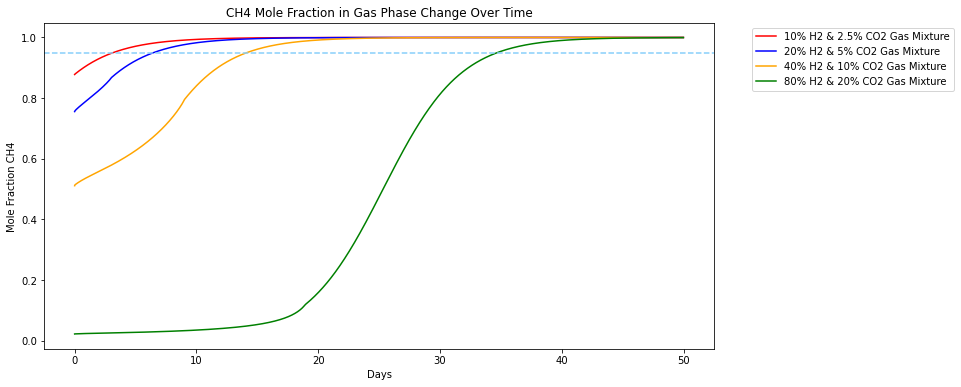

In [59]:
# Plot x_g_CH4 change over time
def simulation_xgCH4_plot(x_g_CH4_10H2, x_g_CH4_20H2, x_g_CH4_40H2, x_g_CH4_80H2):
    fig, (ax1) = plt.subplots(figsize=(12,6))

    ax1.plot(df_time_10H2, x_g_CH4_10H2, color="red", label='10% H2 & 2.5% CO2 Gas Mixture')
    ax1.plot(df_time_20H2, x_g_CH4_20H2, color="blue", label='20% H2 & 5% CO2 Gas Mixture')
    ax1.plot(df_time_40H2, x_g_CH4_40H2, color="orange", label='40% H2 & 10% CO2 Gas Mixture')
    ax1.plot(df_time_80H2, x_g_CH4_80H2, color="green", label='80% H2 & 20% CO2 Gas Mixture')

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Mole Fraction CH4")

    ax1.axhline(y=0.95, color='lightskyblue', linestyle='dashed')
    ax1.set_title("CH4 Mole Fraction in Gas Phase Change Over Time")
    

simulation_xgCH4_plot(x_g_CH4_10H2, x_g_CH4_20H2, x_g_CH4_40H2, x_g_CH4_80H2)

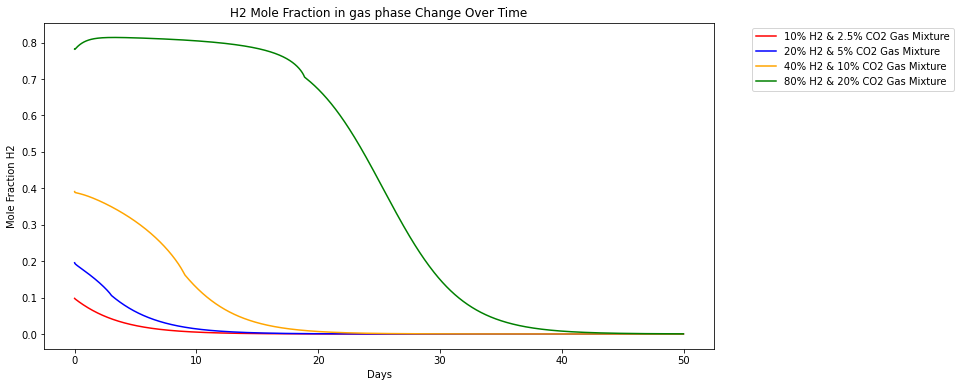

In [33]:
# Plot x_g_H2 change over time
def simulation_xgH2_plot(x_g_H2_10H2, x_g_H2_20H2, x_g_H2_40H2, x_g_H2_80H2):
    fig, (ax1) = plt.subplots(figsize=(12,6))

    ax1.plot(df_time_10H2, x_g_H2_10H2, color="red", label='10% H2 & 2.5% CO2 Gas Mixture')
    ax1.plot(df_time_20H2, x_g_H2_20H2, color="blue", label='20% H2 & 5% CO2 Gas Mixture')
    ax1.plot(df_time_40H2, x_g_H2_40H2, color="orange", label='40% H2 & 10% CO2 Gas Mixture')
    ax1.plot(df_time_80H2, x_g_H2_80H2, color="green", label='80% H2 & 20% CO2 Gas Mixture')

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Mole Fraction H2")

    ax1.set_title("H2 Mole Fraction in gas phase Change Over Time")
    

simulation_xgH2_plot(x_g_H2_10H2, x_g_H2_20H2, x_g_H2_40H2, x_g_H2_80H2)

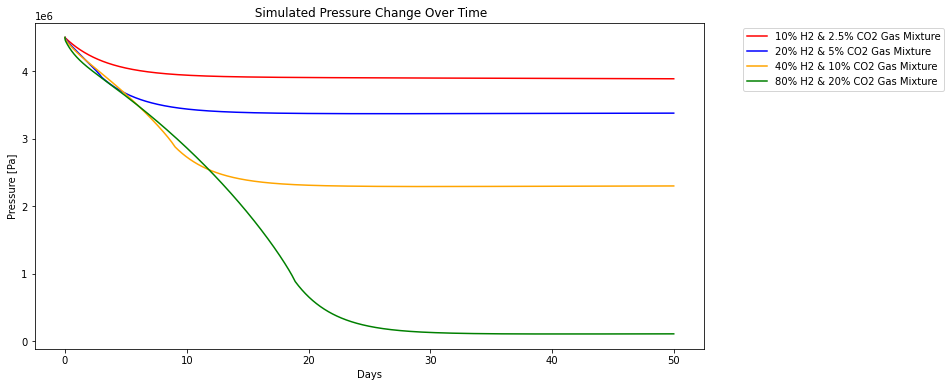

In [13]:
# Plot pressure change over time
def simulation_pressure_plot(pressure_g_sim_10H2, pressure_g_sim_20H2, pressure_g_sim_40H2, pressure_g_sim_80H2):
    fig, (ax1) = plt.subplots(figsize=(12,6))

    ax1.plot(df_time_10H2, pressure_g_sim_10H2, color="red", label='10% H2 & 2.5% CO2 Gas Composition')
    ax1.plot(df_time_20H2, pressure_g_sim_20H2, color="blue", label='20% H2 & 5% CO2 Gas Composition')
    ax1.plot(df_time_40H2, pressure_g_sim_40H2, color="orange", label='40% H2 & 10% CO2 Gas Composition')
    ax1.plot(df_time_80H2, pressure_g_sim_80H2, color="green", label='80% H2 & 20% CO2 Gas Composition')

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Pressure [Pa]")

    ax1.set_title(" Simulated Pressure Change Over Time")

simulation_pressure_plot(pressure_g_sim_10H2, pressure_g_sim_20H2, pressure_g_sim_40H2, pressure_g_sim_80H2)

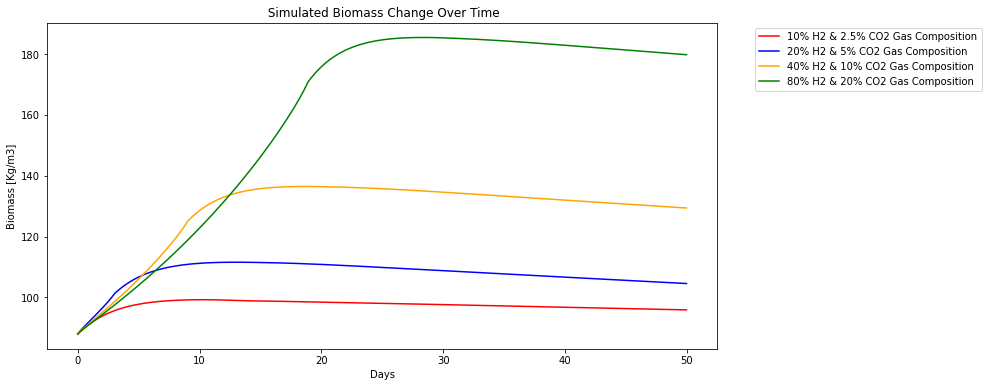

In [31]:
# Plot biomass change over time
def simulation_biomass_plot(biomass_10H2, biomass_20H2, biomass_40H2, biomass_80H2):
    fig, (ax1) = plt.subplots(figsize=(12,6))

    ax1.plot(df_time_10H2, biomass_10H2, color="red", label='10% H2 & 2.5% CO2 Gas Composition')
    ax1.plot(df_time_20H2, biomass_20H2, color="blue", label='20% H2 & 5% CO2 Gas Composition')
    ax1.plot(df_time_40H2, biomass_40H2, color="orange", label='40% H2 & 10% CO2 Gas Composition')
    ax1.plot(df_time_80H2, biomass_80H2, color="green", label='80% H2 & 20% CO2 Gas Composition')

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Biomass [Kg/m3]")

    ax1.set_title(" Simulated Biomass Change Over Time") 

    
simulation_biomass_plot(biomass_10H2, biomass_20H2, biomass_40H2, biomass_80H2)

In [28]:
# Convert liquid saturation to percentage %

S_liq_10H2_percentage = []
S_liq_20H2_percentage = []
S_liq_40H2_percentage = []
S_liq_80H2_percentage = []


def S_liq_conversion(S_liq, S_liq_percentage):
    for i in S_liq:
        s = i * 100
        S_liq_percentage.append(s)


S_liq_conversion(S_liq_10H2, S_liq_10H2_percentage)
S_liq_conversion(S_liq_20H2, S_liq_20H2_percentage)
S_liq_conversion(S_liq_40H2, S_liq_40H2_percentage)
S_liq_conversion(S_liq_80H2, S_liq_80H2_percentage)

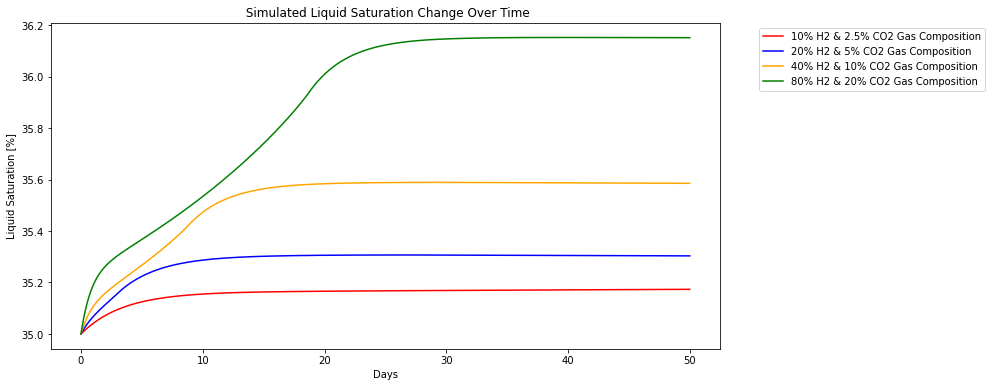

In [32]:
# Plot liquid saturation over time
def simulation_sliq_plot(S_liq_10H2_percentage, S_liq_20H2_percentage, S_liq_40H2_percentage, S_liq_80H2_percentage):
    fig, (ax1) = plt.subplots(figsize=(12,6))

    ax1.plot(df_time_10H2, S_liq_10H2_percentage, color="red", label='10% H2 & 2.5% CO2 Gas Composition')
    ax1.plot(df_time_20H2, S_liq_20H2_percentage, color="blue", label='20% H2 & 5% CO2 Gas Composition')
    ax1.plot(df_time_40H2, S_liq_40H2_percentage, color="orange", label='40% H2 & 10% CO2 Gas Composition')
    ax1.plot(df_time_80H2, S_liq_80H2_percentage, color="green", label='80% H2 & 20% CO2 Gas Composition')

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Liquid Saturation [%]")

    ax1.set_title(" Simulated Liquid Saturation Change Over Time")
    
    
simulation_sliq_plot(S_liq_10H2_percentage, S_liq_20H2_percentage, S_liq_40H2_percentage, S_liq_80H2_percentage)